<a href="https://colab.research.google.com/github/alainray/vision/blob/master/models/EntNet_RelNet_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch torchvision

## Entity Net


Implementation based on "Tracking the World State with Recurrent Entity Networks" (Mikael Henaff, Jason Weston, Arthur Szlam, Antoine Bordes, Yann LeCun) https://arxiv.org/abs/1612.03969

In [0]:
import torch.nn as nn
import torch

class EntNet(nn.Module):
  def __init__(self,nDimensions=100,nMemoryNodes=20,seq_length=70, phi=nn.functional.prelu):
    super(EntNet, self).__init__()
    self.n_dimensions=nDimensions
    self.n_memory_nodes=nMemoryNodes
    self.seq_length=seq_length
    #Parameter matrices
    #Input Transformation
    self.F_i=nn.Parameter(torch.randn(self.n_dimensions, self.seq_length, dtype=torch.float))
    #Dynamic Memory 
    self.memory_nodes=torch.randn(self.n_dimensions, self.n_memory_nodes, dtype=torch.float)
    self.n_memory_nodes=nMemoryNodes
    self.keys=nn.Parameter(torch.randn(self.n_dimensions, self.n_memory_nodes, dtype=torch.float))
    self.U=nn.Parameter(torch.randn(self.n_dimensions, self.n_dimensions, dtype=torch.float))
    self.V=nn.Parameter(torch.randn(self.n_dimensions, self.n_dimensions, dtype=torch.float))
    self.W=nn.Parameter(torch.randn(self.n_dimensions, self.n_dimensions, dtype=torch.float))
    self.g=torch.randn(1, self.n_memory_nodes, dtype=torch.float)
    #Output Transformation
    self.F_q=nn.Parameter(torch.randn(self.n_dimensions, self.seq_length, dtype=torch.float))
    self.R=nn.Parameter(torch.randn(self.n_dimensions, self.n_dimensions, dtype=torch.float))
    self.H=nn.Parameter(torch.randn(self.n_dimensions, self.n_dimensions, dtype=torch.float))
    #Phi function
    self.phi=phi
    #prelu
    self.activation_parameter_mem=nn.Parameter(torch.randn(1,dtype=torch.float))
    self.activation_parameter_out=nn.Parameter(torch.randn(1,dtype=torch.float))

  
  def forward(self,input,query,memory=None):
    input=self.input_step(input,self.F_i)
    query=self.input_step(query,self.F_q)
    self.memory_nodes=self.memory_step(input)
    
    return self.output_step(query)
  
  def input_step(self, input, param):
    #Embedding of input vectors is assumed to be of size n_dimensions
    #Input to the EntNet is a sentence, always assumed to be of size 'seq_length'
    #If shorter, we pad with zero-vectors
    #If longer, we will ignore
    s=torch.zeros(1,self.n_dimensions,dtype=torch.float)
    length=len(input[0])
    for i, vector in enumerate(param.transpose(0,1)):
      if length > i: 
        s=s+vector*input[:,i] 
      else: 
        break
   
    return s.transpose(0,1)
  
  def memory_step(self, input):
    self.g=torch.sigmoid(torch.mm(input.transpose(0,1),self.memory_nodes)+torch.mm(input.transpose(0,1),self.keys))
    candidate_mem=torch.mm(self.U,self.memory_nodes)+torch.mm(self.V,self.keys)+torch.mm(self.W,input)
    candidate_mem=self.phi(candidate_mem,self.activation_parameter_mem)
    new_memory=torch.zeros(self.n_dimensions, self.n_memory_nodes, dtype=torch.float)
    for i,x in enumerate(self.g[0]):
      value=torch.mul(self.memory_nodes[:,i].clone(),(1+x))
      new_memory[:,i]=value
    return nn.functional.normalize(new_memory, p=2, dim=0)
    
  def output_step(self,query):
    p=torch.mm(query.transpose(0,1), self.memory_nodes)
    p=nn.functional.softmax(p,dim=1)
    u=torch.zeros(1,self.n_dimensions,dtype=torch.float)
    for e,p_i in enumerate(p[0]):
      u=u+p_i*self.memory_nodes[:,e]
    
    y=torch.mm(self.R,self.phi(query+torch.mm(self.H,u.transpose(0,1)),self.activation_parameter_out))
    
    return y
  def wipe_memory(self):
    self.memory_nodes=self.keys.clone()


## RelNet

Implementation based on RelNet: End-to-End Modeling of Entities & Relations (Trapit Bansal, Arvind Neelakantan, Andrew McCallum) https://arxiv.org/abs/1706.07179

In [0]:
import torch.nn as nn
import torch

class RelNet(EntNet):
    def __init__(self,
                 nDimensions=100,
                 nMemoryNodes=20,
                 seq_length=70,
                 phi=nn.functional.prelu):
        EntNet.__init__(self,nDimensions,nMemoryNodes,seq_length,phi)        
        #Relational Memory
        self.activation_parameter_rel_mem = nn.Parameter(
            torch.randn(1, dtype=torch.float))
        self.relational_memory = torch.randn(
            self.n_memory_nodes,
            self.n_memory_nodes,
            self.n_dimensions,
            1,
            dtype=torch.float)
        self.A = nn.Parameter(
            torch.randn(
                self.n_dimensions, self.n_dimensions, dtype=torch.float))
        self.B = nn.Parameter(
            torch.randn(
                self.n_dimensions, self.n_dimensions, dtype=torch.float))
        self.C = nn.Parameter(
            torch.randn(
                self.n_dimensions, 3 * self.n_dimensions, dtype=torch.float))

    def forward(self, input, query):

        input = self.input_step(input, self.F_i)
        query = self.input_step(query, self.F_q)
        self.memory_step(input)
        self.relational_step(input)

        return self.output_step(query)

    def relational_step(self, input):
        g_r = torch.zeros(
            self.n_memory_nodes,
            self.n_memory_nodes,
            self.n_dimensions,
            1,
            dtype=torch.float)
        new_input = input.transpose(0, 1)

        for i in range(0, self.n_memory_nodes):
            for j in range(0, self.n_memory_nodes):
                g_r[i][j] = self.g[0][i] * self.g[0][j] * torch.sigmoid(
                    torch.mm(new_input, self.relational_memory[i][j]))

        temp_input = torch.mm(self.B, input)
        candidate_mem = torch.randn(
            self.n_memory_nodes,
            self.n_memory_nodes,
            self.n_dimensions,
            1,
            dtype=torch.float)

        for i in range(0, self.n_memory_nodes):
            for j in range(0, self.n_memory_nodes):
                value = torch.mm(self.A,
                                 self.relational_memory[i][j]) + temp_input
                candidate_mem[i][j] = value

        candidate_mem = self.phi(candidate_mem,
                                 self.activation_parameter_rel_mem)
        new_relational_memory=torch.randn(
            self.n_memory_nodes,
            self.n_memory_nodes,
            self.n_dimensions,
            1,
            dtype=torch.float)
        for i in range(0, self.n_memory_nodes):
            for j in range(0, self.n_memory_nodes):
                new_relational_memory[i][j] =self.relational_memory[i][j]+ g_r[i][j] * candidate_mem[i][j]

        self.relational_memory = nn.functional.normalize(
            new_relational_memory, p=2, dim=2)

    def output_step(self, query):
        candidate_output = torch.zeros(
            self.n_memory_nodes,
            self.n_memory_nodes,
            self.n_dimensions,
            1,
            dtype=torch.float)
        p_ij = torch.zeros(
            self.n_memory_nodes, self.n_memory_nodes, 1, dtype=torch.float)
        
        for i in range(0, self.n_memory_nodes):
            for j in range(0, self.n_memory_nodes):
                mem_temp = torch.cat(
                    (self.memory_nodes[:, i], self.memory_nodes[:, j],
                     self.relational_memory[i][j].view(self.n_dimensions)), 0)
                candidate_output[i][j] = torch.mm(self.C,
                                                  mem_temp.view(
                                                      3 * self.n_dimensions,
                                                      1))
        for i in range(0, self.n_memory_nodes):
          for j in range(0, self.n_memory_nodes):       
            p_ij[i][j] = torch.mm(
            query.transpose(0, 1), candidate_output[i][j])

        new_p_ij = nn.functional.softmax(
            p_ij.view(self.n_memory_nodes * self.n_memory_nodes), dim=0).view(
                self.n_memory_nodes, self.n_memory_nodes, 1)

        u = torch.zeros(self.n_dimensions, 1, dtype=torch.float)

        for i in range(0, self.n_memory_nodes):
            for j in range(0, self.n_memory_nodes):
                u = u + new_p_ij[i][j] * candidate_output[i][j]
        y = torch.mm(self.R,
                     self.phi(query + torch.mm(self.H, u),
                              self.activation_parameter_out))
        return y
      
    def wipe_memory(self):
      self.memory_nodes=self.keys.clone()
      self.relational_memory = torch.randn(
            self.n_memory_nodes,
            self.n_memory_nodes,
            self.n_dimensions,
            1,
            dtype=torch.float)
      #This is probably incorrect, I'll just
      #do an interpolation of the related key values
      for i in range(0, self.n_memory_nodes):
        for j in range(0, self.n_memory_nodes):
          #self.relational_memory[i][j]=(self.keys[:,i].view(self.n_dimensions,1))
          self.relational_memory[i][j]=(self.keys[:,i].view(self.n_dimensions,1)+self.keys[:,j].view(self.n_dimensions,1))/2
            


In [0]:
import torch.optim as opt
import time
def runModel(model,nEpochs,input_data,output_data,query_data,n_print=5):
  n_print=1 #How many epochs until we write an update for the MSE

  errors=list()
  x=list()
  print("Running Model: {}".format(model.__class__.__name__))
  optimizer = opt.Adam(model.parameters(), lr=0.1)
  loss=nn.MSELoss()
  for epoch in range(nEpochs):
    running_loss = 0.0
    
    for i,sample in enumerate(input_data):
      model.zero_grad()
      
      model.wipe_memory()
      
      
      for j,data in enumerate(sample):
        output=model(data, query_data[i])
      
      result=loss(output,output_data[i])

      result.backward()
   
      optimizer.step()

      running_loss += result.item()
   
    error=running_loss/n_samples
    errors.append(error)
    if  epoch % n_print == 0:
      print("Average MSE: {} for Epoch {}".format(error,epoch+1))
  return model, errors #For plotting purposes

In [0]:
dims=50 #How many dimensions we use to encode our vectors
nodes=5 #The amount of memory nodes
seq_length=60 #The max amount of words per sentence
n_samples=20 #How many training examples to generate
n_sentences=10  #How many sentences per training example
input_data=torch.randn(n_samples,n_sentences,dims,seq_length, dtype=torch.float) #Random input
output_data=torch.randn(n_samples,dims,1, dtype=torch.float) #Random output
query_data=torch.randn(n_samples,dims,1, dtype=torch.float) #Random Query 

In [205]:
entnet = EntNet(nDimensions=dims,nMemoryNodes=nodes,seq_length=seq_length)
relnet= RelNet(nDimensions=dims,nMemoryNodes=nodes,seq_length=seq_length)

entnet, errors1=runModel(entnet,10,input_data,output_data,query_data)
relnet, errors2=runModel(relnet,5,input_data,output_data,query_data)

path_entnet='entnet_{}_{}_{}.pth'.format(dims,nodes,seq_length)
path_relnet='relnet_{}_{}_{}.pth'.format(dims,nodes,seq_length)

#torch.save(entnet.state_dict(),path_entnet)
torch.save(relnet.state_dict(),path_relnet)

Running Model: EntNet
Average MSE: 11.6753251076 for Epoch 1
Average MSE: 1.12120084167 for Epoch 2
Average MSE: 1.04656217098 for Epoch 3
Average MSE: 1.00454623997 for Epoch 4
Average MSE: 1.0586976707 for Epoch 5
Average MSE: 1.01676233709 for Epoch 6
Average MSE: 0.950171688199 for Epoch 7
Average MSE: 0.947886255383 for Epoch 8
Average MSE: 0.948726722598 for Epoch 9
Average MSE: 1.03073354065 for Epoch 10
Running Model: RelNet
Average MSE: 223891.681055 for Epoch 1
Average MSE: 28018.8349365 for Epoch 2
Average MSE: 3829.09669132 for Epoch 3
Average MSE: 178.40894472 for Epoch 4
Average MSE: 14.1005173415 for Epoch 5


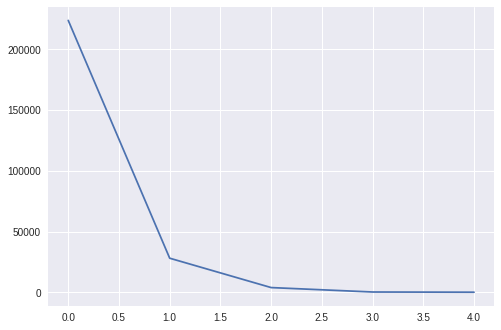

In [207]:
import matplotlib.pyplot as plt
plt.plot(errors2)


In [0]:
#Loading Saved Model
new_model=EntNet(nDimensions=dims,nMemoryNodes=nodes,seq_length=seq_length)
new_model.load_state_dict(torch.load(path_entnet))
print(new_model.state_dict())